In [1]:
%matplotlib inline
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import sys
sys.path.append(os.path.abspath("../.."))
import tensorflow_util.util as util_tf

sys.path.append(os.environ['DATASETS_PATH'])
from mnist.mnist import get_mnist

In [2]:
#create training data

In [3]:
datasets = get_mnist()
data, _ = datasets[0]
print data.shape
NUM_DATA = data.shape[0]

Npixels=28
Nchannels=1
data = data.reshape((NUM_DATA, Npixels, Npixels,1))
print data.shape
print data[0,:].shape

(50000, 784)
(50000, 28, 28, 1)
(28, 28, 1)


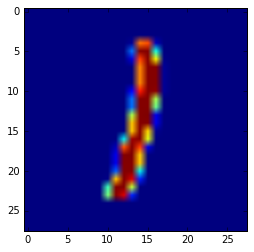

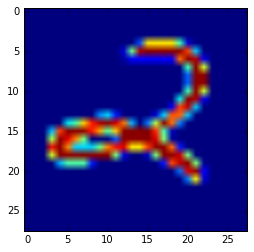

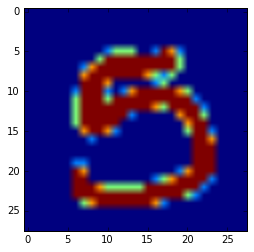

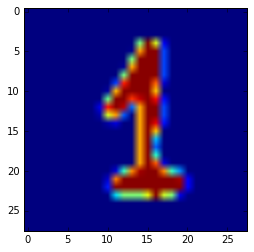

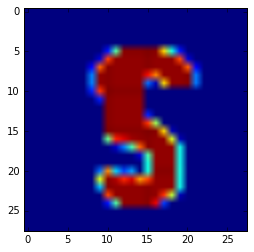

In [4]:
#plot some random images
Num_images_to_plot = 5
for i in range(0,Num_images_to_plot):
    index = np.random.randint(NUM_DATA)
    
    plt.imshow(data[index,:,:,0])
    plt.show()

In [5]:
means = np.mean(data, axis=(0,1,2))
stdevs = np.std(data,axis=(0,1,2))

print means
print stdevs

data_norm = (data-means)/stdevs

print np.mean(data_norm, axis=(0,1,2))
print np.std(data_norm,axis=(0,1,2))

[ 0.13044983]
[ 0.30728981]
[ -3.16381460e-07]
[ 0.99999934]


In [6]:
#set up generator network
from keras.models import Model
from keras.layers import Input, Dense, Convolution2D, UpSampling2D, Flatten, Reshape, merge, BatchNormalization
from keras.optimizers import Adam
NOISE_DIM = 100
NBATCH = 25
Nfilters = 64
W = 3
lrg = 1e-4
lrd = 1e-3

adamg = Adam(lr=lrg)
adamd = Adam(lr=lrd)

z = Input(shape=(NOISE_DIM,))
g = Dense(Npixels**2, activation='relu')(z)

g = Reshape((Npixels,Npixels,1))(g)

g = Convolution2D(Nfilters,W,W, activation='relu', border_mode='same')(g)

g = Convolution2D(1,W,W, activation='linear', border_mode='same')(g)

Generator = Model(z,g)
Generator.compile(optimizer=adamg,loss='binary_crossentropy')

Using TensorFlow backend.


In [7]:
#set up discriminator network
x = Input(shape=(Npixels,Npixels,1))

d = Convolution2D(Nfilters,W,W,activation='relu')(x)
d = BatchNormalization(mode=2)(d)
d = Convolution2D(Nfilters,W,W,activation='relu')(d)
d = BatchNormalization(mode=2)(d)
d = Convolution2D(Nfilters,W,W,activation='relu')(d)
d = BatchNormalization(mode=2)(d)
d = Flatten()(d)
d = Dense(2, activation='softmax')(d)

Discriminator = Model(x,d)
Discriminator.compile(optimizer=adamd, loss='categorical_crossentropy', metrics=['accuracy'])
Discriminator.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 28, 28, 1)     0                                            
____________________________________________________________________________________________________
convolution2d_3 (Convolution2D)  (None, 26, 26, 64)    640         input_2[0][0]                    
____________________________________________________________________________________________________
batchnormalization_1 (BatchNormal(None, 26, 26, 64)    128         convolution2d_3[0][0]            
____________________________________________________________________________________________________
convolution2d_4 (Convolution2D)  (None, 24, 24, 64)    36928       batchnormalization_1[0][0]       
___________________________________________________________________________________________

In [8]:
h = Generator(z)
out_fake = Discriminator(h)
Discriminator.trainable = False
Gen_classifier = Model(z,out_fake)
Gen_classifier.compile(optimizer=adamg, loss='categorical_crossentropy')
Gen_classifier.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 100)           0                                            
____________________________________________________________________________________________________
model_1 (Model)                  (None, 28, 28, 1)     80401       input_1[0][0]                    
____________________________________________________________________________________________________
model_2 (Model)                  (None, 2)             136834      model_1[1][0]                    
Total params: 217235
____________________________________________________________________________________________________


In [9]:
def get_batch(xdata, nbatch):
    N = xdata.shape[0]
    inds = np.random.choice(N, size=nbatch, replace=False)
    xret = xdata[inds,:]

    return xret

In [12]:
num_batch = 100

z_pre = np.random.rand(num_batch*NBATCH,NOISE_DIM)
x_pre = get_batch(data_norm,num_batch*NBATCH)
print x_pre.shape
x_gan = Generator.predict(z_pre,batch_size=num_batch*NBATCH)
print x_gan.shape
X = np.vstack((x_pre,x_gan))
print X.shape
y = np.zeros((X.shape[0],2))

y[:X.shape[0]/2,0]=1
y[X.shape[0]/2:,1]=1

Discriminator.trainable = True
Discriminator.fit(X,y,nb_epoch=1,batch_size=32)


(2500, 28, 28, 1)
(2500, 28, 28, 1)
(5000, 28, 28, 1)
Epoch 1/1
5000/5000 [==============================] - 17s - loss: 1.1921e-07 - acc: 1.0000    


In [13]:
print y[0:10]
print y[X.shape[0]/2:X.shape[0]/2+10]
print Discriminator.predict(x_pre[0:10])
print Discriminator.predict(x_gan[0:10])

[[ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]]
[[ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]]
[[  9.99751985e-01   2.47992808e-04]
 [  9.80407417e-01   1.95925664e-02]
 [  5.50468154e-02   9.44953144e-01]
 [  9.92802560e-01   7.19740894e-03]
 [  1.00000000e+00   4.15164593e-13]
 [  9.98785198e-01   1.21478538e-03]
 [  1.00000000e+00   1.01721653e-09]
 [  1.00000000e+00   7.70911113e-10]
 [  1.00000000e+00   6.70009679e-16]
 [  1.00000000e+00   2.43633520e-12]]
[[  4.59719710e-02   9.54028010e-01]
 [  6.45377804e-05   9.99935508e-01]
 [  6.15479887e-01   3.84520084e-01]
 [  9.99975443e-01   2.45057290e-05]
 [  9.92433906e-01   7.56605435e-03]
 [  9.38910842e-01   6.10891730e-02]
 [  1.58955791e-05   9.99984145e-01]
 [  9.99999523e-01   4.47715962e-07]
 [  1.48855020e-06   9.99998569e-01]
 [  1.00000000e+00   3.05569037e-09]]


In [16]:
Niter = 100

Yd = np.zeros((2*NBATCH,2))
Yd[:NBATCH,0]=1
Yd[NBATCH:,1]=1

Yg = np.zeros((NBATCH,2))
Yg[:,0]=1

print_step = 10

for i in range(0,Niter):
    z_batch = np.random.rand(NBATCH,NOISE_DIM)
    
    x_gan = Generator.predict(z_batch,batch_size=NBATCH)
    x_batch = get_batch(data_norm,NBATCH)
    
    X = np.vstack((x_batch,x_gan))
    
    ld = Discriminator.train_on_batch(X,Yd)
    
    z_batch = np.random.rand(NBATCH,NOISE_DIM)
    lg = Gen_classifier.train_on_batch(z_batch,Yg)
    
    if (i % print_step) ==0:
        print "Discriminator loss={}, Generator loss={}".format(ld, lg)

Discriminator loss=[1.1920929e-07, 1.0], Generator loss=1.60136580467
Discriminator loss=[1.6379529e-06, 1.0], Generator loss=1.19209289551e-07
Discriminator loss=[1.1920929e-07, 1.0], Generator loss=1.19209289551e-07
Discriminator loss=[1.1920929e-07, 1.0], Generator loss=1.19209289551e-07
Discriminator loss=[1.1920929e-07, 1.0], Generator loss=1.19209289551e-07
Discriminator loss=[1.1920929e-07, 1.0], Generator loss=1.19209289551e-07
Discriminator loss=[2.0027178e-07, 1.0], Generator loss=1.19209289551e-07
Discriminator loss=[1.1920929e-07, 1.0], Generator loss=1.19209289551e-07
Discriminator loss=[1.1920929e-07, 1.0], Generator loss=1.19209289551e-07
Discriminator loss=[1.1920929e-07, 1.0], Generator loss=1.19209289551e-07


In [19]:
print Discriminator.train_on_batch(x_gan,Yd[NBATCH:,:])
print Gen_classifier.predict(z_batch)
print Discriminator.predict(x_gan)

[16.118093, 0.0]
[[  1.00000000e+00   8.46670999e-24]
 [  1.00000000e+00   3.33866405e-14]
 [  1.00000000e+00   1.42536450e-22]
 [  1.00000000e+00   4.73056811e-25]
 [  1.00000000e+00   3.24064175e-27]
 [  1.00000000e+00   4.52781704e-20]
 [  1.00000000e+00   3.81371662e-22]
 [  1.00000000e+00   2.19128672e-22]
 [  1.00000000e+00   1.20701573e-25]
 [  1.00000000e+00   1.89568742e-19]
 [  1.00000000e+00   5.39878127e-21]
 [  1.00000000e+00   7.20670197e-27]
 [  1.00000000e+00   3.46495067e-23]
 [  1.00000000e+00   1.13937156e-17]
 [  1.00000000e+00   1.54608447e-16]
 [  1.00000000e+00   3.21117709e-22]
 [  1.00000000e+00   8.28412813e-23]
 [  1.00000000e+00   1.13888980e-16]
 [  1.00000000e+00   4.56247158e-22]
 [  1.00000000e+00   8.26502744e-24]
 [  1.00000000e+00   4.80691198e-19]
 [  1.00000000e+00   1.17039493e-22]
 [  1.00000000e+00   1.12314818e-28]
 [  1.00000000e+00   7.48175332e-21]
 [  1.00000000e+00   1.24783861e-22]]
[[  1.00000000e+00   9.27109173e-24]
 [  1.00000000e+00  

In [22]:
print Yd
print Discriminator.predict(X)

[[ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]]
[[  1.00000000e+00   2.38331853e-19]
 [  1.00000000e+00   1.76092154e-16]
 [  1.00000000e+00   7.48357192e-12]
 [  1.00000000e+00   7.99404338e-16]
 [  1.00000000e+00   7.37502455e-17]
 [  1.00000000e+00   5.43125744e-12]
 [  1.00000000e+00   1.76266857e-09]
 [  1.00000000e+00   1.43199059e-16]
 [  1.00000000e+00   2.49221816e-16]
 [  9.99374568e-01   6.25430432e-04]
 [  1.00000000e+00   6.23921539e-11]
 [  1.00000000e+00   9.77340943e-18]
 [  9

In [ ]:
Num_images_to_plot = 5
imgs = Generator.predict(z_batch)
print imgs.shape
for i in range(0,Num_images_to_plot):
    index = np.random.randint(imgs.shape[0])
    
    plt.imshow(imgs[index,:,:,0])
    plt.show()